# Analysis of TextGrad with TextualVerifier

- Comparative analysis for 6 different versiosn of TextGrad & TextualVerifier combination
- Author: Eugenius Mario Situmorang
- Date: June 2025

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [35]:
print("=== TextGrad Experiment Analysis ===")
print("Comparing 6 different configurations:\n")
print("1. textgrad-only: Basic TextGrad optimization")
print("2. textgrad-tv-l: TextGrad + TextualVerifier for Loss only")
print("3. textgrad-tv-o-1v: TextGrad + TextualVerifier for Optimizer (1 variant)")
print("4. textgrad-tv-o-3v: TextGrad + TextualVerifier for Optimizer (3 variants)")
print("5. textgrad-tv-lo-1v: TextGrad + TextualVerifier for Loss + Optimizer (1 variant)")
print("6. textgrad-tv-lo-3v: TextGrad + TextualVerifier for Loss + Optimizer (3 variants)")
print("\n" + "="*80 + "\n")

# Load all datasets
datasets = {
    'textgrad-only': 'results/textgrad-only.csv',
    'textgrad-tv-l': 'results/textgrad-tv-l.csv', 
    'textgrad-tv-o-1v': 'results/textgrad-tv-o-1v.csv',
    'textgrad-tv-o-1v-mmlu-ml': 'results/textgrad-tv-o-1v-mmlu-ml.csv',
    'textgrad-tv-o-1v-longer': 'results/textgrad-tv-o-1v-longer.csv',
    'textgrad-tv-o-1v-using-vars': 'results/textgrad-tv-o-1v-using-vars.csv',
    'textgrad-tv-o-3v': 'results/textgrad-tv-o-3v.csv',
    'textgrad-tv-lo-1v': 'results/textgrad-tv-lo-1v.csv',
    'textgrad-tv-lo-3v': 'results/textgrad-tv-lo-3v.csv',
}

dfs = {}
for name, path in datasets.items():
    try:
        df = pd.read_csv(path)
        df['method'] = name
        dfs[name] = df
        print(f"✓ Loaded {name}: {len(df)} samples")
    except FileNotFoundError:
        print(f"✗ File not found: {path}")
    except Exception as e:
        print(f"✗ Error loading {name}: {str(e)}")

print(f"\nSuccessfully loaded {len(dfs)} datasets")

=== TextGrad Experiment Analysis ===
Comparing 6 different configurations:

1. textgrad-only: Basic TextGrad optimization
2. textgrad-tv-l: TextGrad + TextualVerifier for Loss only
3. textgrad-tv-o-1v: TextGrad + TextualVerifier for Optimizer (1 variant)
4. textgrad-tv-o-3v: TextGrad + TextualVerifier for Optimizer (3 variants)
5. textgrad-tv-lo-1v: TextGrad + TextualVerifier for Loss + Optimizer (1 variant)
6. textgrad-tv-lo-3v: TextGrad + TextualVerifier for Loss + Optimizer (3 variants)


✓ Loaded textgrad-only: 412 samples
✓ Loaded textgrad-tv-l: 412 samples
✓ Loaded textgrad-tv-o-1v: 412 samples
✓ Loaded textgrad-tv-o-1v-mmlu-ml: 112 samples
✓ Loaded textgrad-tv-o-1v-longer: 412 samples
✓ Loaded textgrad-tv-o-1v-using-vars: 412 samples
✓ Loaded textgrad-tv-o-3v: 412 samples
✓ Loaded textgrad-tv-lo-1v: 412 samples
✓ Loaded textgrad-tv-lo-3v: 412 samples

Successfully loaded 9 datasets


## METRIC DEFINITIONS

In [36]:
def extract_answer_from_solution(solution_text):
    """Extract the final answer (A, B, C, or D) from solution text"""
    if pd.isna(solution_text) or solution_text == "":
        return None
    
    # Look for "Answer: X" pattern at the end
    import re
    answer_pattern = r'Answer:\s*([ABCD])'
    matches = re.findall(answer_pattern, str(solution_text))
    if matches:
        return matches[-1]  # Take the last occurrence
    
    # Alternative: look for just a single letter at the end
    letter_pattern = r'\b([ABCD])\s*$'
    matches = re.findall(letter_pattern, str(solution_text).strip())
    if matches:
        return matches[-1]
    
    return None

def calculate_accuracy(df):
    """Calculate accuracy based on correct vs final answer"""
    if 'final_solution_answer' not in df.columns:
        return 0.0
    
    # Extract answers from both columns
    df['extracted_final'] = df['final_solution_answer'].apply(extract_answer_from_solution)
    df['extracted_correct'] = df['correct_answer'].apply(lambda x: x.strip() if pd.notna(x) else None)
    
    # Count correct answers
    correct_mask = (df['extracted_final'] == df['extracted_correct']) & df['extracted_final'].notna()
    return correct_mask.sum() / len(df) if len(df) > 0 else 0.0

def analyze_method_performance(method_df):
    """Analyze performance metrics for a single method"""
    metrics = {}
    
    # Basic success metrics
    total_samples = len(method_df)
    successful_samples = method_df['success'].sum() if 'success' in method_df.columns else 0
    failed_samples = total_samples - successful_samples
    
    metrics['total_samples'] = total_samples
    metrics['successful_samples'] = successful_samples
    metrics['failed_samples'] = failed_samples
    metrics['success_rate'] = successful_samples / total_samples if total_samples > 0 else 0.0
    
    # Accuracy (for successful samples only)
    if successful_samples > 0:
        successful_df = method_df[method_df['success'] == True].copy()
        metrics['accuracy'] = calculate_accuracy(successful_df)
        metrics['accuracy_overall'] = calculate_accuracy(method_df)
    else:
        metrics['accuracy'] = 0.0
        metrics['accuracy_overall'] = 0.0
    
    # Performance metrics (for successful samples)
    if successful_samples > 0:
        perf_df = method_df[method_df['success'] == True]
        
        metrics['avg_processing_time'] = perf_df['processing_time_ms'].mean()
        metrics['median_processing_time'] = perf_df['processing_time_ms'].median()
        metrics['std_processing_time'] = perf_df['processing_time_ms'].std()
        
        metrics['avg_llm_calls'] = perf_df['total_llm_calls'].mean()
        metrics['median_llm_calls'] = perf_df['total_llm_calls'].median()
        metrics['std_llm_calls'] = perf_df['total_llm_calls'].std()
        
        metrics['avg_input_tokens'] = perf_df['total_input_tokens'].mean()
        metrics['avg_output_tokens'] = perf_df['total_output_tokens'].mean()
        metrics['avg_total_tokens'] = metrics['avg_input_tokens'] + metrics['avg_output_tokens']
        
    else:
        # Set defaults for failed methods
        for key in ['avg_processing_time', 'median_processing_time', 'std_processing_time',
                   'avg_llm_calls', 'median_llm_calls', 'std_llm_calls',
                   'avg_input_tokens', 'avg_output_tokens', 'avg_total_tokens']:
            metrics[key] = 0.0
    
    return metrics

## PERFORMANCE ANALYSIS

In [37]:
print("PERFORMANCE ANALYSIS")
print("="*50)

# Analyze each method overall
method_results = {}
for method_name, df in dfs.items():
    print(f"\nAnalyzing {method_name}...")
    metrics = analyze_method_performance(df)
    method_results[method_name] = metrics
    
    print(f"  • Total samples: {metrics['total_samples']}")
    print(f"  • Success rate: {metrics['success_rate']:.1%}")
    print(f"  • Accuracy (successful only): {metrics['accuracy']:.1%}")
    print(f"  • Overall accuracy: {metrics['accuracy_overall']:.1%}")
    if metrics['successful_samples'] > 0:
        print(f"  • Avg LLM calls: {metrics['avg_llm_calls']:.1f}")
        print(f"  • Avg processing time: {metrics['avg_processing_time']:.1f}ms")
        print(f"  • Avg total tokens: {metrics['avg_total_tokens']:.0f}")

# Create summary dataframe
summary_df = pd.DataFrame(method_results).T
summary_df = summary_df.round(3)

print(f"\n{'='*80}")
print("OVERALL SUMMARY TABLE")
print("="*80)
print(summary_df[['success_rate', 'accuracy_overall', 'avg_llm_calls', 
                  'avg_processing_time', 'avg_total_tokens']].to_string())


PERFORMANCE ANALYSIS

Analyzing textgrad-only...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 68.2%
  • Overall accuracy: 68.2%
  • Avg LLM calls: 0.0
  • Avg processing time: 0.0ms
  • Avg total tokens: 0

Analyzing textgrad-tv-l...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 69.2%
  • Overall accuracy: 69.2%
  • Avg LLM calls: 1.0
  • Avg processing time: 7.8ms
  • Avg total tokens: 391

Analyzing textgrad-tv-o-1v...
  • Total samples: 412
  • Success rate: 100.0%
  • Accuracy (successful only): 65.0%
  • Overall accuracy: 65.0%
  • Avg LLM calls: 9.6
  • Avg processing time: 67.1ms
  • Avg total tokens: 7754

Analyzing textgrad-tv-o-1v-mmlu-ml...
  • Total samples: 112
  • Success rate: 100.0%
  • Accuracy (successful only): 62.5%
  • Overall accuracy: 62.5%
  • Avg LLM calls: 8.7
  • Avg processing time: 14187.8ms
  • Avg total tokens: 6668

Analyzing textgrad-tv-o-1v-longer...
  • Total samples: 412
  • Success

## SOURCE-SPECIFIC ANALYSIS

In [38]:
print(f"\n{'='*80}")
print("SOURCE-SPECIFIC ANALYSIS")
print("="*80)

# Define the sources to analyze
sources = ['GPQA-Diamond', 'MMLU-ML', 'MMLU-CP']

# Analyze by source
source_results = {}
for source in sources:
    print(f"\n--- {source} Dataset ---")
    source_results[source] = {}
    
    for method_name, df in dfs.items():
        # Filter by source
        source_df = df[df['source'] == source] if 'source' in df.columns else pd.DataFrame()
        
        if len(source_df) > 0:
            metrics = analyze_method_performance(source_df)
            source_results[source][method_name] = metrics
            
            print(f"\n{method_name}:")
            print(f"  • Samples: {metrics['total_samples']}")
            print(f"  • Success rate: {metrics['success_rate']:.1%}")
            print(f"  • Overall accuracy: {metrics['accuracy_overall']:.1%}")
            if metrics['successful_samples'] > 0:
                print(f"  • Avg LLM calls: {metrics['avg_llm_calls']:.1f}")
                print(f"  • Avg processing time: {metrics['avg_processing_time']:.1f}ms")
        else:
            print(f"\n{method_name}: No samples found")
            source_results[source][method_name] = None

# Create source-specific summary tables
for source in sources:
    if any(result is not None for result in source_results[source].values()):
        print(f"\n{'='*60}")
        print(f"{source} SUMMARY TABLE")
        print("="*60)
        
        source_summary = {}
        for method_name, metrics in source_results[source].items():
            if metrics is not None:
                source_summary[method_name] = metrics
        
        if source_summary:
            source_df = pd.DataFrame(source_summary).T
            source_df = source_df.round(3)
            print(source_df[['success_rate', 'accuracy_overall', 'avg_llm_calls', 
                           'avg_processing_time', 'avg_total_tokens']].to_string())


SOURCE-SPECIFIC ANALYSIS

--- GPQA-Diamond Dataset ---

textgrad-only:
  • Samples: 198
  • Success rate: 100.0%
  • Overall accuracy: 53.0%
  • Avg LLM calls: 0.0
  • Avg processing time: 0.0ms

textgrad-tv-l:
  • Samples: 198
  • Success rate: 100.0%
  • Overall accuracy: 53.5%
  • Avg LLM calls: 1.0
  • Avg processing time: 11.2ms

textgrad-tv-o-1v:
  • Samples: 198
  • Success rate: 100.0%
  • Overall accuracy: 55.1%
  • Avg LLM calls: 10.4
  • Avg processing time: 95.0ms

textgrad-tv-o-1v-mmlu-ml: No samples found

textgrad-tv-o-1v-longer:
  • Samples: 198
  • Success rate: 100.0%
  • Overall accuracy: 52.0%
  • Avg LLM calls: 10.4
  • Avg processing time: 20822.1ms

textgrad-tv-o-1v-using-vars:
  • Samples: 198
  • Success rate: 100.0%
  • Overall accuracy: 55.6%
  • Avg LLM calls: 10.4
  • Avg processing time: 20895.2ms

textgrad-tv-o-3v:
  • Samples: 198
  • Success rate: 100.0%
  • Overall accuracy: 55.1%
  • Avg LLM calls: 38.7
  • Avg processing time: 172083.7ms

textgrad-t

## VISUALIZATIONS

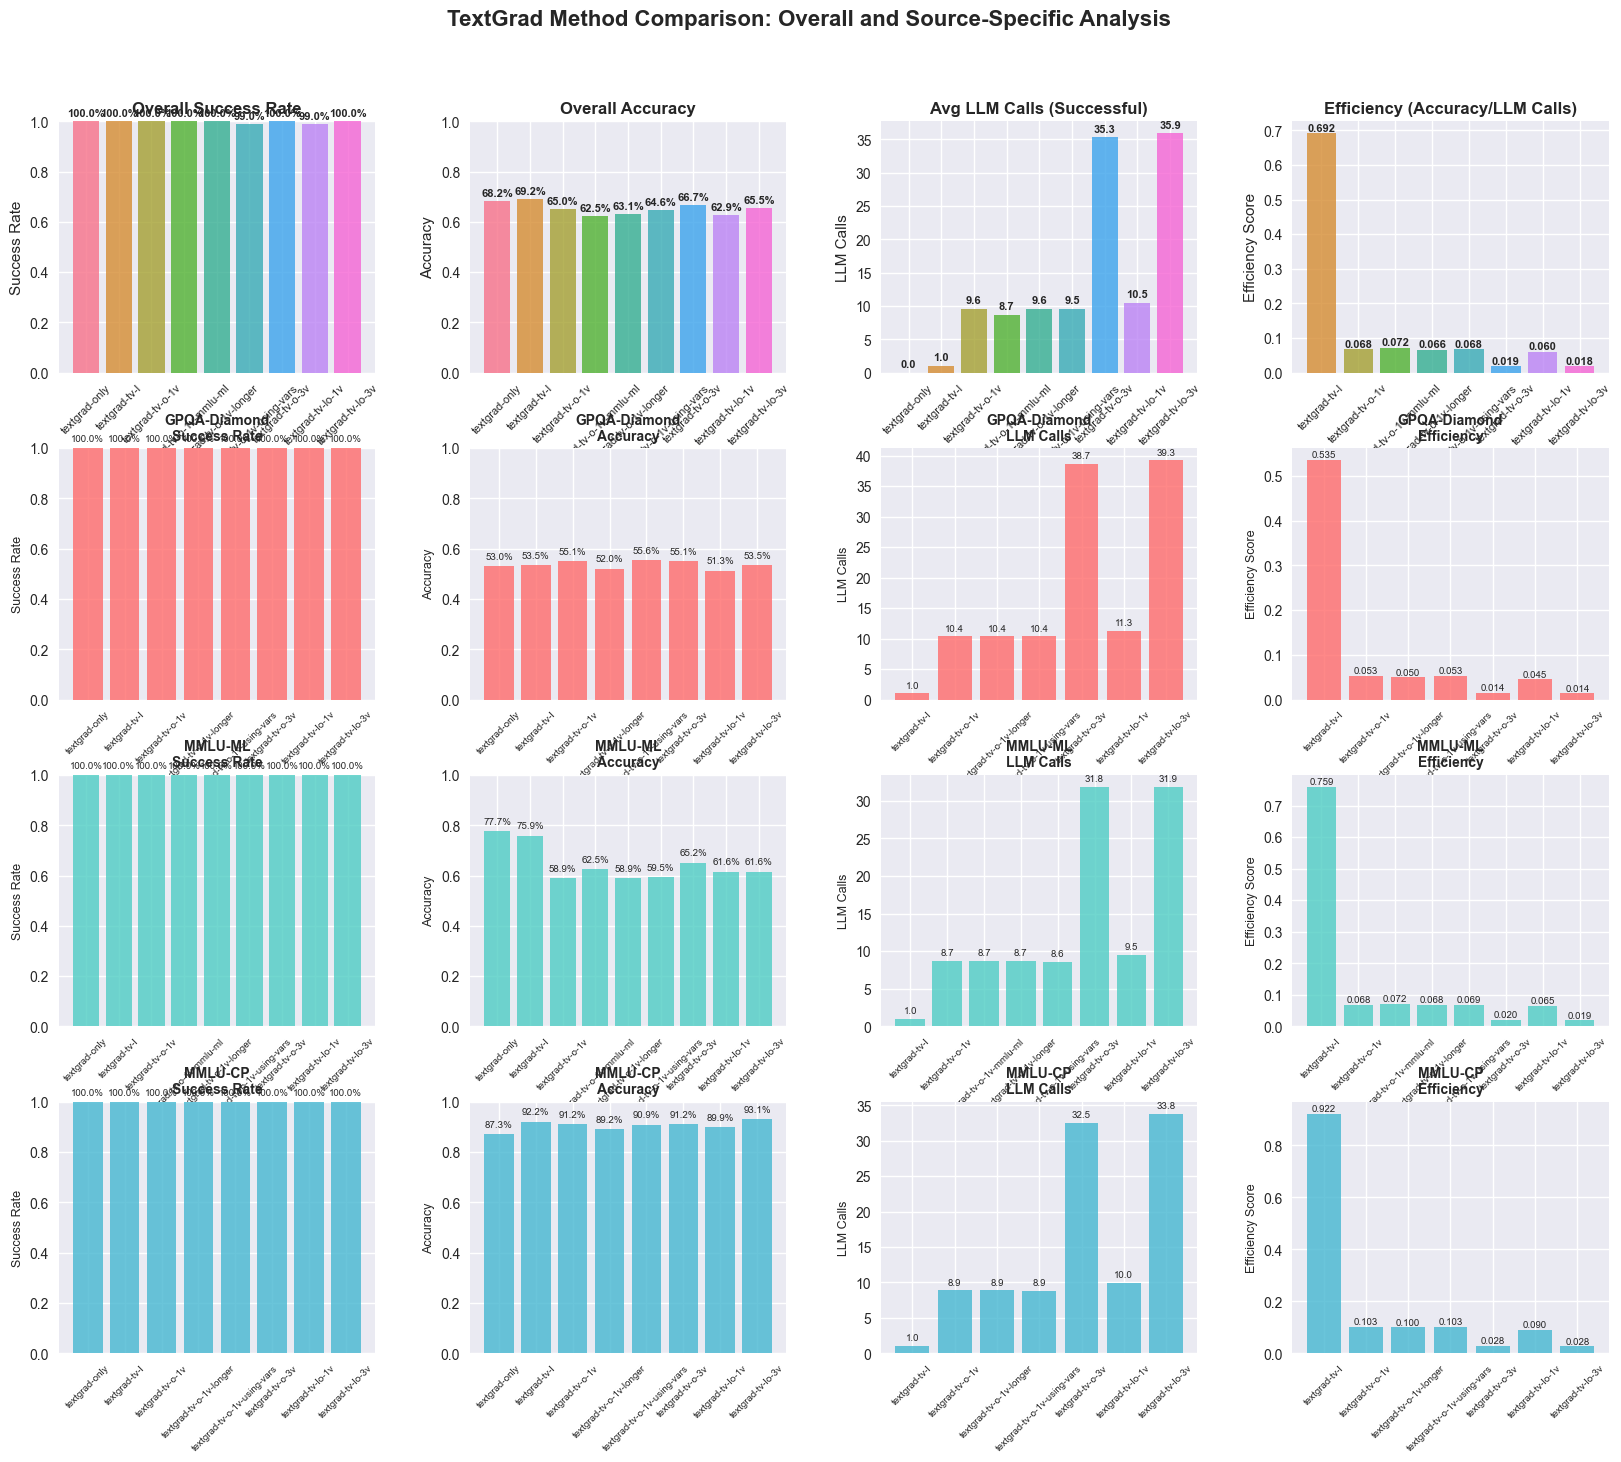

In [39]:
# Create comprehensive visualization with source-specific analysis
fig = plt.figure(figsize=(20, 16))

# Create a grid layout: 3 rows (overall + 2 source rows), 4 columns
gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 1], hspace=0.3, wspace=0.3)

# Overall analysis (top row)
fig.suptitle('TextGrad Method Comparison: Overall and Source-Specific Analysis', 
             fontsize=16, fontweight='bold', y=0.95)

# Row 1: Overall Performance
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

methods = list(summary_df.index)
colors = sns.color_palette("husl", len(methods))

# 1. Overall Success Rate
success_rates = summary_df['success_rate'].values
bars1 = ax1.bar(methods, success_rates, color=colors, alpha=0.8)
ax1.set_title('Overall Success Rate', fontweight='bold')
ax1.set_ylabel('Success Rate')
ax1.set_ylim(0, 1.0)
ax1.tick_params(axis='x', rotation=45, labelsize=8)

for bar, rate in zip(bars1, success_rates):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{rate:.1%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 2. Overall Accuracy
accuracy_rates = summary_df['accuracy_overall'].values
bars2 = ax2.bar(methods, accuracy_rates, color=colors, alpha=0.8)
ax2.set_title('Overall Accuracy', fontweight='bold')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.0)
ax2.tick_params(axis='x', rotation=45, labelsize=8)

for bar, acc in zip(bars2, accuracy_rates):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.1%}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 3. LLM Calls (successful methods only)
successful_methods = []
successful_llm_calls = []
successful_colors = []

for i, (method, metrics) in enumerate(method_results.items()):
    if metrics['successful_samples'] > 0:
        successful_methods.append(method)
        successful_llm_calls.append(metrics['avg_llm_calls'])
        successful_colors.append(colors[i])

if successful_methods:
    bars3 = ax3.bar(successful_methods, successful_llm_calls, color=successful_colors, alpha=0.8)
    ax3.set_title('Avg LLM Calls (Successful)', fontweight='bold')
    ax3.set_ylabel('LLM Calls')
    ax3.tick_params(axis='x', rotation=45, labelsize=8)
    
    for bar, calls in zip(bars3, successful_llm_calls):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{calls:.1f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Efficiency Score
if successful_methods:
    efficiency_scores = []
    efficiency_labels = []
    efficiency_colors = []
    
    for i, method in enumerate(successful_methods):
        metrics = method_results[method]
        if metrics['avg_llm_calls'] > 0:
            efficiency = metrics['accuracy_overall'] / metrics['avg_llm_calls']
            efficiency_scores.append(efficiency)
            efficiency_labels.append(method)
            efficiency_colors.append(successful_colors[i])
    
    if efficiency_scores:
        bars4 = ax4.bar(efficiency_labels, efficiency_scores, color=efficiency_colors, alpha=0.8)
        ax4.set_title('Efficiency (Accuracy/LLM Calls)', fontweight='bold')
        ax4.set_ylabel('Efficiency Score')
        ax4.tick_params(axis='x', rotation=45, labelsize=8)
        
        for bar, eff in zip(bars4, efficiency_scores):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                     f'{eff:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Source-specific analysis (rows 2-4)
sources = ['GPQA-Diamond', 'MMLU-ML', 'MMLU-CP']
source_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for row_idx, source in enumerate(sources, start=1):
    # Extract data for this source
    source_methods = []
    source_success_rates = []
    source_accuracies = []
    source_llm_calls = []
    source_efficiencies = []
    
    if source in source_results:
        for method_name, metrics in source_results[source].items():
            if metrics is not None and metrics['total_samples'] > 0:
                source_methods.append(method_name)
                source_success_rates.append(metrics['success_rate'])
                source_accuracies.append(metrics['accuracy_overall'])
                
                if metrics['successful_samples'] > 0:
                    source_llm_calls.append(metrics['avg_llm_calls'])
                    if metrics['avg_llm_calls'] > 0:
                        source_efficiencies.append(metrics['accuracy_overall'] / metrics['avg_llm_calls'])
                    else:
                        source_efficiencies.append(0)
                else:
                    source_llm_calls.append(0)
                    source_efficiencies.append(0)
    
    if source_methods:
        # Success Rate for this source
        ax_success = fig.add_subplot(gs[row_idx, 0])
        bars = ax_success.bar(source_methods, source_success_rates, 
                             color=source_colors[row_idx-1], alpha=0.8)
        ax_success.set_title(f'{source}\nSuccess Rate', fontweight='bold', fontsize=10)
        ax_success.set_ylabel('Success Rate', fontsize=9)
        ax_success.set_ylim(0, 1.0)
        ax_success.tick_params(axis='x', rotation=45, labelsize=7)
        
        for bar, rate in zip(bars, source_success_rates):
            height = bar.get_height()
            ax_success.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                           f'{rate:.1%}', ha='center', va='bottom', fontsize=7)
        
        # Accuracy for this source
        ax_acc = fig.add_subplot(gs[row_idx, 1])
        bars = ax_acc.bar(source_methods, source_accuracies, 
                         color=source_colors[row_idx-1], alpha=0.8)
        ax_acc.set_title(f'{source}\nAccuracy', fontweight='bold', fontsize=10)
        ax_acc.set_ylabel('Accuracy', fontsize=9)
        ax_acc.set_ylim(0, 1.0)
        ax_acc.tick_params(axis='x', rotation=45, labelsize=7)
        
        for bar, acc in zip(bars, source_accuracies):
            height = bar.get_height()
            ax_acc.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{acc:.1%}', ha='center', va='bottom', fontsize=7)
        
        # LLM Calls for this source (only successful methods)
        ax_llm = fig.add_subplot(gs[row_idx, 2])
        successful_source_methods = [m for i, m in enumerate(source_methods) if source_llm_calls[i] > 0]
        successful_source_calls = [c for c in source_llm_calls if c > 0]
        
        if successful_source_methods:
            bars = ax_llm.bar(successful_source_methods, successful_source_calls, 
                             color=source_colors[row_idx-1], alpha=0.8)
            ax_llm.set_title(f'{source}\nLLM Calls', fontweight='bold', fontsize=10)
            ax_llm.set_ylabel('LLM Calls', fontsize=9)
            ax_llm.tick_params(axis='x', rotation=45, labelsize=7)
            
            for bar, calls in zip(bars, successful_source_calls):
                height = bar.get_height()
                ax_llm.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                           f'{calls:.1f}', ha='center', va='bottom', fontsize=7)
        else:
            ax_llm.text(0.5, 0.5, 'No successful\nsamples', ha='center', va='center', 
                       transform=ax_llm.transAxes, fontsize=9)
            ax_llm.set_title(f'{source}\nLLM Calls', fontweight='bold', fontsize=10)
        
        # Efficiency for this source
        ax_eff = fig.add_subplot(gs[row_idx, 3])
        efficient_methods = [m for i, m in enumerate(source_methods) if source_efficiencies[i] > 0]
        efficient_scores = [e for e in source_efficiencies if e > 0]
        
        if efficient_methods:
            bars = ax_eff.bar(efficient_methods, efficient_scores, 
                             color=source_colors[row_idx-1], alpha=0.8)
            ax_eff.set_title(f'{source}\nEfficiency', fontweight='bold', fontsize=10)
            ax_eff.set_ylabel('Efficiency Score', fontsize=9)
            ax_eff.tick_params(axis='x', rotation=45, labelsize=7)
            
            for bar, eff in zip(bars, efficient_scores):
                height = bar.get_height()
                ax_eff.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                           f'{eff:.3f}', ha='center', va='bottom', fontsize=7)
        else:
            ax_eff.text(0.5, 0.5, 'No efficiency\ndata', ha='center', va='center', 
                       transform=ax_eff.transAxes, fontsize=9)
            ax_eff.set_title(f'{source}\nEfficiency', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## DETAILED METRICS TABLE

In [40]:
print(f"\n{'='*80}")
print("DETAILED METRICS TABLE - OVERALL")
print("="*80)

detailed_metrics = []
for method_name, metrics in method_results.items():
    row = {
        'Method': method_name,
        'Total Samples': metrics['total_samples'],
        'Success Rate': f"{metrics['success_rate']:.1%}",
        'Overall Accuracy': f"{metrics['accuracy_overall']:.1%}",
        'Accuracy (Success Only)': f"{metrics['accuracy']:.1%}",
        'Avg LLM Calls': f"{metrics['avg_llm_calls']:.1f}",
        'Median LLM Calls': f"{metrics['median_llm_calls']:.1f}",
        'Avg Processing Time (ms)': f"{metrics['avg_processing_time']:.1f}",
        'Avg Input Tokens': f"{metrics['avg_input_tokens']:.0f}",
        'Avg Output Tokens': f"{metrics['avg_output_tokens']:.0f}",
        'Avg Total Tokens': f"{metrics['avg_total_tokens']:.0f}",
    }
    detailed_metrics.append(row)

detailed_df = pd.DataFrame(detailed_metrics)
print(detailed_df.to_string(index=False))

# Source-specific detailed tables
for source in sources:
    if source in source_results and any(result is not None for result in source_results[source].values()):
        print(f"\n{'='*80}")
        print(f"DETAILED METRICS TABLE - {source}")
        print("="*80)
        
        source_detailed_metrics = []
        for method_name, metrics in source_results[source].items():
            if metrics is not None:
                row = {
                    'Method': method_name,
                    'Total Samples': metrics['total_samples'],
                    'Success Rate': f"{metrics['success_rate']:.1%}",
                    'Overall Accuracy': f"{metrics['accuracy_overall']:.1%}",
                    'Accuracy (Success Only)': f"{metrics['accuracy']:.1%}",
                    'Avg LLM Calls': f"{metrics['avg_llm_calls']:.1f}",
                    'Avg Processing Time (ms)': f"{metrics['avg_processing_time']:.1f}",
                    'Avg Total Tokens': f"{metrics['avg_total_tokens']:.0f}",
                }
                source_detailed_metrics.append(row)
        
        if source_detailed_metrics:
            source_detailed_df = pd.DataFrame(source_detailed_metrics)
            print(source_detailed_df.to_string(index=False))


DETAILED METRICS TABLE - OVERALL
                     Method  Total Samples Success Rate Overall Accuracy Accuracy (Success Only) Avg LLM Calls Median LLM Calls Avg Processing Time (ms) Avg Input Tokens Avg Output Tokens Avg Total Tokens
              textgrad-only            412       100.0%            68.2%                   68.2%           0.0              0.0                      0.0                0                 0                0
              textgrad-tv-l            412       100.0%            69.2%                   69.2%           1.0              1.0                      7.8              338                53              391
           textgrad-tv-o-1v            412       100.0%            65.0%                   65.0%           9.6              8.0                     67.1             7300               454             7754
   textgrad-tv-o-1v-mmlu-ml            112       100.0%            62.5%                   62.5%           8.7              7.0                  1

## RECOMMENDATIONS

In [41]:
print(f"\n{'='*80}")
print("ANALYSIS & RECOMMENDATIONS")
print("="*80)

# Find best performing methods
best_success_rate = max(method_results.items(), key=lambda x: x[1]['success_rate'])
best_accuracy = max(method_results.items(), key=lambda x: x[1]['accuracy_overall'])

successful_methods_results = {k: v for k, v in method_results.items() if v['successful_samples'] > 0}
if successful_methods_results:
    best_efficiency = min(successful_methods_results.items(), 
                         key=lambda x: x[1]['avg_llm_calls'] if x[1]['avg_llm_calls'] > 0 else float('inf'))
    best_speed = min(successful_methods_results.items(), 
                    key=lambda x: x[1]['avg_processing_time'])

print(f"\n🏆 BEST PERFORMERS:")
print(f"  • Highest Success Rate: {best_success_rate[0]} ({best_success_rate[1]['success_rate']:.1%})")
print(f"  • Highest Overall Accuracy: {best_accuracy[0]} ({best_accuracy[1]['accuracy_overall']:.1%})")

if successful_methods_results:
    print(f"  • Most Efficient (fewest LLM calls): {best_efficiency[0]} ({best_efficiency[1]['avg_llm_calls']:.1f} calls)")
    print(f"  • Fastest Processing: {best_speed[0]} ({best_speed[1]['avg_processing_time']:.1f}ms)")

print(f"\n📊 KEY INSIGHTS:")

# Analyze TextualVerifier impact
tv_methods = [m for m in method_results.keys() if 'tv' in m and method_results[m]['successful_samples'] > 0]
non_tv_methods = [m for m in method_results.keys() if 'tv' not in m and method_results[m]['successful_samples'] > 0]

if tv_methods and non_tv_methods:
    avg_accuracy_tv = np.mean([method_results[m]['accuracy_overall'] for m in tv_methods])
    avg_accuracy_non_tv = np.mean([method_results[m]['accuracy_overall'] for m in non_tv_methods])
    
    avg_calls_tv = np.mean([method_results[m]['avg_llm_calls'] for m in tv_methods])
    avg_calls_non_tv = np.mean([method_results[m]['avg_llm_calls'] for m in non_tv_methods])
    
    print(f"  • TextualVerifier Impact:")
    print(f"    - Accuracy: TV methods {avg_accuracy_tv:.1%} vs Non-TV {avg_accuracy_non_tv:.1%}")
    print(f"    - LLM Calls: TV methods {avg_calls_tv:.1f} vs Non-TV {avg_calls_non_tv:.1f}")

# Analyze component-specific TextualVerifier impact
loss_only_methods = [m for m in method_results.keys() if 'tv-l' in m and method_results[m]['successful_samples'] > 0]
optimizer_methods = [m for m in method_results.keys() if 'tv-o' in m and method_results[m]['successful_samples'] > 0]
combined_methods = [m for m in method_results.keys() if 'tv-lo' in m and method_results[m]['successful_samples'] > 0]

if loss_only_methods:
    avg_acc_loss = np.mean([method_results[m]['accuracy_overall'] for m in loss_only_methods])
    print(f"  • Loss-only TextualVerifier: {avg_acc_loss:.1%} accuracy")

if optimizer_methods:
    avg_acc_opt = np.mean([method_results[m]['accuracy_overall'] for m in optimizer_methods])
    print(f"  • Optimizer-only TextualVerifier: {avg_acc_opt:.1%} accuracy")

if combined_methods:
    avg_acc_combined = np.mean([method_results[m]['accuracy_overall'] for m in combined_methods])
    print(f"  • Combined Loss+Optimizer TextualVerifier: {avg_acc_combined:.1%} accuracy")

# Analyze variant impact
variant_1_methods = [m for m in method_results.keys() if '1v' in m and method_results[m]['successful_samples'] > 0]
variant_3_methods = [m for m in method_results.keys() if '3v' in m and method_results[m]['successful_samples'] > 0]

if variant_1_methods and variant_3_methods:
    avg_accuracy_1v = np.mean([method_results[m]['accuracy_overall'] for m in variant_1_methods])
    avg_accuracy_3v = np.mean([method_results[m]['accuracy_overall'] for m in variant_3_methods])
    
    print(f"  • Multi-variant Impact:")
    print(f"    - 1 variant: {avg_accuracy_1v:.1%} accuracy")
    print(f"    - 3 variants: {avg_accuracy_3v:.1%} accuracy")

print(f"\n💡 RECOMMENDATIONS:")
print(f"  1. For highest success rate: Use {best_success_rate[0]}")
print(f"  2. For best accuracy: Use {best_accuracy[0]}")
if successful_methods_results:
    print(f"  3. For efficiency: Use {best_efficiency[0]} (good accuracy with fewer LLM calls)")
    print(f"  4. For speed: Use {best_speed[0]} (fastest processing)")

print(f"\n🔍 TEXTUALVERIFIER ANALYSIS:")
if tv_methods and non_tv_methods:
    improvement = avg_accuracy_tv - avg_accuracy_non_tv
    cost_increase = avg_calls_tv - avg_calls_non_tv
    print(f"  • TextualVerifier provides {improvement:+.1%} accuracy improvement")
    print(f"  • At cost of {cost_increase:+.1f} additional LLM calls per sample")
    print(f"  • ROI: {improvement/cost_increase:.3f} accuracy points per additional call" if cost_increase > 0 else "")

print(f"\n⚠️  NOTE: Methods with 0% success rate likely had implementation issues")
print(f"    and should be debugged before production use.")

print(f"\n📋 METHODOLOGY INSIGHTS:")
print(f"  • TextualVerifier (TV) adds verification layers to TextGrad optimization")
print(f"  • 'L' variants verify loss calculations")
print(f"  • 'O' variants verify optimizer steps") 
print(f"  • 'LO' variants verify both loss and optimizer")
print(f"  • Multiple variants (1v vs 3v) test robustness through repetition")

print(f"\n{'='*80}")
print("Analysis Complete!")
print("="*80)


ANALYSIS & RECOMMENDATIONS

🏆 BEST PERFORMERS:
  • Highest Success Rate: textgrad-only (100.0%)
  • Highest Overall Accuracy: textgrad-tv-l (69.2%)
  • Most Efficient (fewest LLM calls): textgrad-tv-l (1.0 calls)
  • Fastest Processing: textgrad-only (0.0ms)

📊 KEY INSIGHTS:
  • TextualVerifier Impact:
    - Accuracy: TV methods 64.9% vs Non-TV 68.2%
    - LLM Calls: TV methods 15.0 vs Non-TV 0.0
  • Loss-only TextualVerifier: 65.9% accuracy
  • Optimizer-only TextualVerifier: 64.4% accuracy
  • Combined Loss+Optimizer TextualVerifier: 64.2% accuracy
  • Multi-variant Impact:
    - 1 variant: 63.6% accuracy
    - 3 variants: 66.1% accuracy

💡 RECOMMENDATIONS:
  1. For highest success rate: Use textgrad-only
  2. For best accuracy: Use textgrad-tv-l
  3. For efficiency: Use textgrad-tv-l (good accuracy with fewer LLM calls)
  4. For speed: Use textgrad-only (fastest processing)

🔍 TEXTUALVERIFIER ANALYSIS:
  • TextualVerifier provides -3.3% accuracy improvement
  • At cost of +15.0 add